# Intro

- 유투브 영상의 Views를 예측하는 회귀모델을 만들고자 한다.
- 총 6개의 모델 (En, RF, MLP, XGB, SVM, KNN)을 만들고 해당 모델들을 Voting 앙상블 하여 최적의 모델을 도출하였다.

# 5. 모델 생성 및 최적화
----

- 여러개의 모델을 만들어서 각각에 데이터를 적용

In [51]:
# 여러개의 모델 결과를 df로 만들기 위한 공통 list생성
model_name = []
train_perf = []
test_perf = []

## ElasticNet

Fitting 5 folds for each of 1900 candidates, totalling 9500 fits
Best_estimator: ElasticNet(alpha=0.002700000000000001, l1_ratio=0.9, max_iter=100000000,
           random_state=42, tol=0.1)
Best_params: {'alpha': 0.002700000000000001, 'l1_ratio': 0.9, 'tol': 0.1}
Best_score: 0.7474337468194194
Train score: 0.7533408115852761
Test  score: 0.5587733983078278


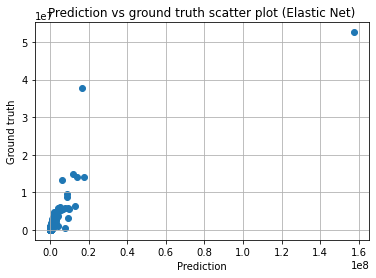

In [52]:
# 모델 선언
# 계산 부하가 적은 모델이므로 max_iter은 충분하게 부여한다.
en_model = ElasticNet(max_iter=100000000, random_state=42)


# 파라미터 최적화 범위 설정
"""
- l1_ratio : L1 & L2 규제 중 어느 것을 더 많이 사용할 것인가.
             0~1 사이 값. 1-l1_ratio = L2 ratio
- alpha : 가중치
- tol : threshold를 어느정도의 값 이하로 진행될 것인가.
"""
en_param = {'l1_ratio': np.arange(0.9, 0.995, 0.005),
            'alpha': np.arange(0.0008, 0.0028, 0.0001),
            'tol': [1e-2, 3.16e-2, 1e-1, 3.16e-1, 1e0]}


# GridSearch 로 hyper parameter 튜닝
"""
n_jobs = -1 : 모든 core를 사용하겠다.
verbose=3 : 진행 상황을 얼마나 자주 report할 것인지
"""
clf = GridSearchCV(estimator=en_model, param_grid=en_param, n_jobs=-1, verbose=3)
clf.fit(x_train_scaled, y_train) # data input
y_train_pred = clf.predict(x_train_scaled) # train_prediction
y_test_pred = clf.predict(x_test_scaled) # test_prediction

# Parameter 추출
print('Best_estimator:', clf.best_estimator_)
print('Best_params:', clf.best_params_)
print('Best_score:', clf.best_score_)

# Train & Test의 score 추출하여 비교 by r2_score
train_score = r2_score(y_train_pred, y_train)
print('Train score:', train_score)
test_score = r2_score(y_test_pred, y_test)
print('Test  score:', test_score)

# 결과를 공통 list에 저장
model_name.append('Elastic Net')
train_perf.append(train_score)
test_perf.append(test_score)

# 결과 시각화 with scatter plot
plt.title('Prediction vs ground truth scatter plot (Elastic Net)')
plt.xlabel('Prediction')
plt.ylabel('Ground truth')
plt.grid()
plt.scatter(y_test_pred, y_test);

In [73]:
# 최적의 결과를 모델에 적용
en_model = ElasticNet(alpha=0.0027, l1_ratio=0.9, tol=0.1, max_iter=100000000, random_state=42)

## Random Forest Regressor

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best_estimator: RandomForestRegressor(max_depth=30, n_estimators=96, n_jobs=-1, random_state=42)
Best_params: {'max_depth': 30, 'min_samples_split': 2, 'n_estimators': 96}
Best_score: 0.7177836574357326
Train score: 0.9357138691827017
Test  score: 0.7504533464068426


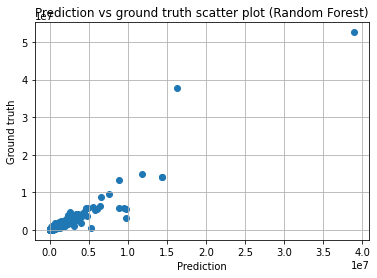

In [54]:
rf_model = RandomForestRegressor(n_jobs=-1, random_state=42) # 모델 정의

# parameter 정의
"""
n_estimators : bagging 하는 tree의 개수
max_depth : tree의 깊이 (데이터의 성질, 품질, 양에 따라 다르다.)
min_samples_split : split하는 최소 sample의 개수
"""
rf_param = {'n_estimators': range(76, 136, 20),
            'max_depth': range(30, 42, 4),
            'min_samples_split': range(2, 5, 1)}

clf = GridSearchCV(estimator=rf_model, param_grid=rf_param, n_jobs=-1, verbose=2)

clf.fit(x_train_scaled, y_train)
y_train_pred = clf.predict(x_train_scaled)
y_test_pred = clf.predict(x_test_scaled)

print('Best_estimator:', clf.best_estimator_)
print('Best_params:', clf.best_params_)
print('Best_score:', clf.best_score_)
train_score = r2_score(y_train_pred, y_train)
print('Train score:', train_score)
test_score = r2_score(y_test_pred, y_test)
print('Test  score:', test_score)

model_name.append('Random Forest')
train_perf.append(train_score)
test_perf.append(test_score)

plt.title('Prediction vs ground truth scatter plot (Random Forest)')
plt.xlabel('Prediction')
plt.ylabel('Ground truth')
plt.grid()
plt.scatter(y_test_pred, y_test);

- ElasticNet에 비해 Test score이 많이 향상되었다.

In [72]:
# 최적의 결과를 모델에 적용
rf_model = RandomForestRegressor(n_estimators=96, max_depth=30, min_samples_split=2, n_jobs=-1, random_state=42)

### Random Forest의 feature importance 확인

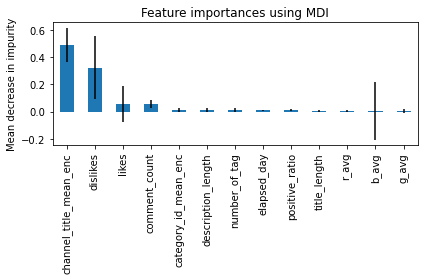

In [74]:
# 적용된 최적의 모델의 feature importance 

rf_model.fit(x_train_scaled, y_train)

feature_names = ['feature {i}' for i in range(x_train_scaled.shape[1])]

# feature importance 추출
importances = rf_model.feature_importances_

# standard deviation 추출
std = np.std([tree.feature_importances_ for tree in rf_model.estimators_], axis=0)

# Series로 변환 & importance가 큰 순으로 정렬
forest_importances = pd.Series(importances, index=features)
forest_importances = forest_importances.sort_values(ascending=False)

# 시각화
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

- channel_title_mean_enc와 dislike가 중요한 feature인 것을 알 수 있다. (양/음의 관계 단정 지으면 안된다.)
- likes 이하의 feature들은 사실상 거의 의미없는 feature 인 것으로 보인다.

### Random Forest의 permutation importance 확인

- 특정 feature의 값을 임으로 변경했을때, 얼마나 target값에 대한 정확도가 나빠지는지(error이 얼마나 증가하나)를 확인
- feature importance와 동일 
- 단, feature importance는 tree 기반 모델에서만 추출이 가능하지만, permutation importance는 prediction이 가능한 모든 모델에서 사용 가능하다.

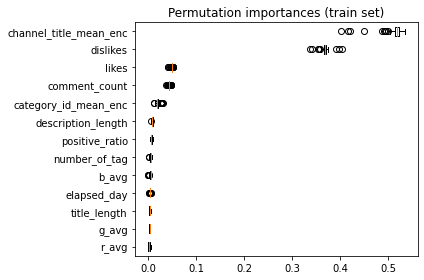

In [75]:
"""
각 feature에서 random value를 사용하기 때문에 random_state를 적용해도 일정하지 않을 수 있다.
이를 보완하기 위해 n_repeats를 충분하게 부여한다.(사양이 허락하는한 최대한 많이 주면 줄수록 좋다.)

"""
result = permutation_importance(rf_model, x_train_scaled, y_train, n_repeats=100, n_jobs=-1, random_state=42) # permutation 추출
sorted_idx = result.importances_mean.argsort() # 결과 sort

fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T, vert=False, labels=x_train.columns[sorted_idx])
ax.set_title("Permutation importances (train set)")
fig.tight_layout()

- feature importance 와 비슷하게 channel_title_mean_enc와 dislike가 중요한 feature임을 알 수 있다.
- 다만, permutation importance가 조금 더 정교한 결과를 보여준다.

## MLP(Multi Layer Perceptron) Regressor

- Randomized search 사용 : 차원이 넓고, 범위가 넓은 데이터는 Grid search로 촘촘하게 하기보다는 Randomized search 를 하는 것이 효율적이다.
- Grid search 로 세세하게 훑어 보면 좋지만, 하드웨어의 물리적 한계를 고려해 효율성을 따진 것
- 일반적으로 신경망 연산을 할때는 Grid 보다는 Random이 효율적이다.

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best_estimator: MLPRegressor(alpha=0.0006798962421591127, early_stopping=True,
             hidden_layer_sizes=(29, 28, 28, 29), learning_rate='adaptive',
             max_iter=2000000, random_state=42, verbose=0)
Best_params: {'alpha': 0.0006798962421591127, 'hidden_layer_sizes': (29, 28, 28, 29)}
Best_score: 0.697647847386584
Train score: 0.7436959102690992
Test  score: 0.5915119564549477


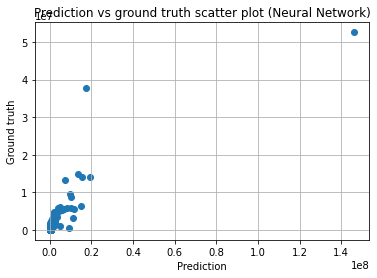

In [58]:
"""
learning_rate : 오차율 변화를 adaptive하게 변화 (default 는 constant)
                초반에는 learning_rate를 크게 가다가, 후반부에 작게 가는 방식
early_stopping : iteration이 진행될때 loss의 변화가 적다면(모델 개선이 없다면) 중지 (before max_iteration)
"""

# 모델 선언
mlp_model = MLPRegressor(learning_rate='adaptive', max_iter=2000000, verbose=0,
                         early_stopping=True, random_state=42)

# 파라미터 설정
"""
hidden_layer_sizes : 각 layer마다 tuple 형태로 입력이 가능하다.
                     itertools.product를 활용해서 24 ~32 사이의 숫자로 4번을 반복해서 값을 생성 -> tuple로 생성
alpha : 규제를 어느정도 할 것인가. log scale이 의미가 있다.
        loguniform을 활용해서 값을 선정
"""

mlp_param = {'hidden_layer_sizes': [x for x in itertools.product((range(24, 32)), repeat=4)],
             'alpha': loguniform(1e-4, 1e-3)}

# Randomized search 사용
# 성능 측정용으로 10회만 (n_iter=10)
rand_clf = RandomizedSearchCV(estimator=mlp_model, param_distributions=mlp_param, n_iter=10, n_jobs=-1,
                              cv=3, verbose=2, random_state=42)

# data input
rand_clf.fit(x_train_scaled, y_train)

# prediction
y_train_pred = rand_clf.predict(x_train_scaled)
y_test_pred = rand_clf.predict(x_test_scaled)

# 결과 확인
print('Best_estimator:', rand_clf.best_estimator_)
print('Best_params:', rand_clf.best_params_)
print('Best_score:', rand_clf.best_score_)
train_score = r2_score(y_train_pred, y_train)
print('Train score:', train_score)
test_score = r2_score(y_test_pred, y_test)
print('Test  score:', test_score)

# 결과 시각화 with scatter plot
model_name.append('Neural Network')
train_perf.append(train_score)
test_perf.append(test_score)
plt.title('Prediction vs ground truth scatter plot (Neural Network)')
plt.xlabel('Prediction')
plt.ylabel('Ground truth')
plt.grid()
plt.scatter(y_test_pred, y_test);

In [71]:
# 최적의 결과를 모델에 적용
mlp_model = MLPRegressor(hidden_layer_sizes=(24, 27, 28, 31), alpha=0.0006798962421591127, learning_rate='adaptive',
                         max_iter=2000000, verbose=0, early_stopping=True, random_state=42)

## XGB Regressor

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best_estimator: XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=3, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=120, n_jobs=-1,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0.01, reg_lambda=0.316, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)
Best_params: {'max_depth': 3, 'n_estimators': 120, 'reg_alpha': 0.01, 'reg_lambda': 0.316}
Best_score: 0.7728576061581535
Train score: 0.9974929391469998
Test  score: 0.7697238403965264


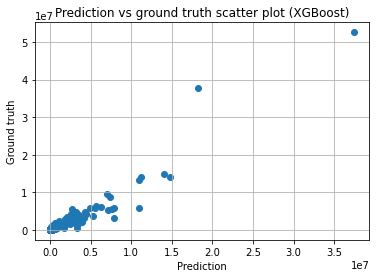

In [60]:
# 모델 선언
xgb_model = XGBRegressor(n_jobs=-1, random_state=42)


# parameter 설정
"""
규제 파라미터 2개 
reg_alpha
reg_lambda
"""
xgb_param = {'n_estimators': range(80, 140, 20),
             'max_depth': range(2, 5, 1),
             'reg_alpha': [1e-2, 3.16e-2, 1e-1],
             'reg_lambda': [0.1, 0.316, 1]}


# hyper parameter tunning
xgb_clf = GridSearchCV(estimator=xgb_model, param_grid=xgb_param, n_jobs=-1, verbose=2, cv=3)

# 모델에 적용
xgb_clf.fit(x_train_scaled, y_train)
y_train_pred = xgb_clf.predict(x_train_scaled)
y_test_pred = xgb_clf.predict(x_test_scaled)

print('Best_estimator:', xgb_clf.best_estimator_)
print('Best_params:', xgb_clf.best_params_)
print('Best_score:', xgb_clf.best_score_)
train_score = r2_score(y_train_pred, y_train)
print('Train score:', train_score)
test_score = r2_score(y_test_pred, y_test)
print('Test  score:', test_score)

model_name.append('XGBoost')
train_perf.append(train_score)
test_perf.append(test_score)

plt.title('Prediction vs ground truth scatter plot (XGBoost)')
plt.xlabel('Prediction')
plt.ylabel('Ground truth')
plt.grid()
plt.scatter(y_test_pred, y_test)

In [70]:
# 최적의 결과를 모델에 적용
xgb_model = XGBRegressor(max_depth=3, n_estimators=120, reg_alpha=0.01, reg_lambda=0.316, n_jobs=-1, random_state=42)

## SVM Regressor

Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best_estimator: SVR(C=100000000.0, gamma=0.1)
Best_params: {'C': 100000000.0, 'gamma': 0.1}
Best_score: 0.7914325900067363
Train score: 0.7499666867872967
Test  score: -0.6093163425621284


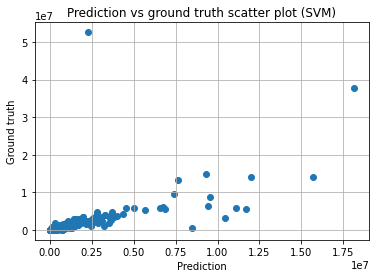

In [62]:
# 모델선언
svr_model = SVR()


# parameter 
"""
C : 얼마나 많은 데이터 샘플이 다른 클래스로 분류되는 것을 허용할 것인가 (높을수록 기준이 tight)
gamma : 하나의 데이터 샘플이 영향력을 행사하는 거리 (클수록 작은 표준편차를 갖는다)
"""
svr_param = {'C': [3.16e7, 1e8],
             'gamma': [0.1, 0.316]}

svr_clf = GridSearchCV(estimator=svr_model, param_grid=svr_param, n_jobs=-1, verbose=3, cv=3)

svr_clf.fit(x_train_scaled, y_train)
y_train_pred = svr_clf.predict(x_train_scaled)
y_test_pred = svr_clf.predict(x_test_scaled)

print('Best_estimator:', svr_clf.best_estimator_)
print('Best_params:', svr_clf.best_params_)
print('Best_score:', svr_clf.best_score_)
train_score = r2_score(y_train_pred, y_train)
print('Train score:', train_score)
test_score = r2_score(y_test_pred, y_test)
print('Test  score:', test_score)

model_name.append('SVM')
train_perf.append(train_score)
test_perf.append(test_score)

plt.title('Prediction vs ground truth scatter plot (SVM)')
plt.xlabel('Prediction')
plt.ylabel('Ground truth')
plt.grid()
plt.scatter(y_test_pred, y_test)

- SVM의 Test값이 음수값으로 나온다 = 데이터 해석이 불가능 하다 = 현재 데이터에 부적합한 모델이다 = 앙상블을 해도 쓰지 않아야 한다.

In [69]:
# 최적의 결과를 모델에 적용
svr_model = SVR(C=100000000, gamma=0.1)

## KNN Regressor

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best_estimator: KNeighborsRegressor(leaf_size=1, n_jobs=-1, n_neighbors=4, weights='distance')
Best_params: {'leaf_size': 1, 'n_neighbors': 4, 'weights': 'distance'}
Best_score: 0.6356002675099257
Train score: 1.0
Test  score: 0.40071256810039


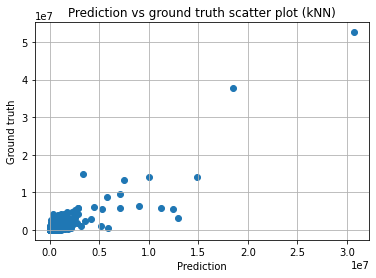

In [64]:
# 모델 선언
knn_model = KNeighborsRegressor(n_jobs=-1)

# parameter
knn_param = {'n_neighbors': range(1, 6, 1),
             'weights': ['uniform', 'distance'],
             'leaf_size': range(1, 5, 1)}

knn_clf = GridSearchCV(estimator=knn_model, param_grid=knn_param, n_jobs=-1, verbose=3)

knn_clf.fit(x_train_scaled, y_train)
y_train_pred = knn_clf.predict(x_train_scaled)
y_test_pred = knn_clf.predict(x_test_scaled)

print('Best_estimator:', knn_clf.best_estimator_)
print('Best_params:', knn_clf.best_params_)
print('Best_score:', knn_clf.best_score_)

train_score = r2_score(y_train_pred, y_train)
print('Train score:', train_score)
test_score = r2_score(y_test_pred, y_test)
print('Test  score:', test_score)

model_name.append('KNN')
train_perf.append(train_score)
test_perf.append(test_score)

plt.title('Prediction vs ground truth scatter plot (kNN)')
plt.xlabel('Prediction')
plt.ylabel('Ground truth')
plt.grid()
plt.scatter(y_test_pred, y_test);

In [68]:
# 최적의 결과를 모델에 적용
knn_model = KNeighborsRegressor(leaf_size=1, n_neighbors=4 , n_jobs=-1, weights='distance')

## 각 모델별 성능 시각화

In [66]:
# 해석 불가 모델인  SVM은 제거
model_name.remove('SVM')
del train_perf[4] # 5번째 model
del test_perf[4]
model_name

['Elastic Net', 'Random Forest', 'Neural Network', 'XGBoost', 'KNN']

In [76]:
dic = {'model_name':model_name,
      'train_perf':train_perf,
      'test_perf':test_perf}

MPC = pd.DataFrame.from_dict(dic, orient='index')
MPC

,0,1,2,3,4
model_name,Elastic Net,Random Forest,Neural Network,XGBoost,KNN
train_perf,0.75,0.94,0.74,1.00,1.00
test_perf,0.56,0.75,0.59,0.77,0.40


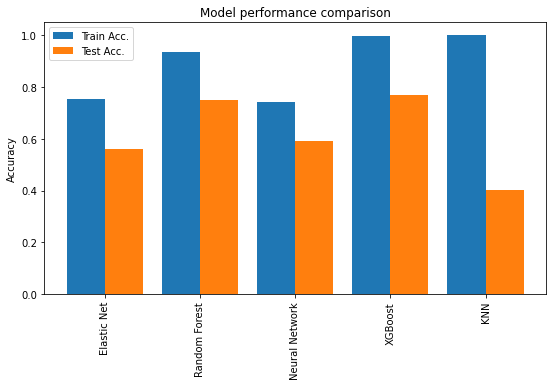

In [77]:
plt.rcParams['figure.figsize'] = (9, 5)
plt.title('Model performance comparison')
plt.xticks(rotation=90)
plt.ylabel('Accuracy')

x = np.arange(len(model_name))
plt.xticks(x, model_name)
plt.bar(x - 0.2, train_perf, width=0.4, label='Train Acc.')
plt.bar(x + 0.2, test_perf, width=0.4, label='Test Acc.')
plt.legend();

# 모델 앙상블 by Voting

1 Ensemble train score: 0.9974929391469998
1 Ensemble test  score: 0.7697238403965264 

2 Ensemble train score: 0.9844179059971965
2 Ensemble test  score: 0.7646699599356265 

3 Ensemble train score: 0.9459696939727981
3 Ensemble test  score: 0.8579955934106758 

4 Ensemble train score: 0.9132062544470099
4 Ensemble test  score: 0.7791599850635491 

5 Ensemble train score: 0.9469212124110686
5 Ensemble test  score: 0.8209624647024927 



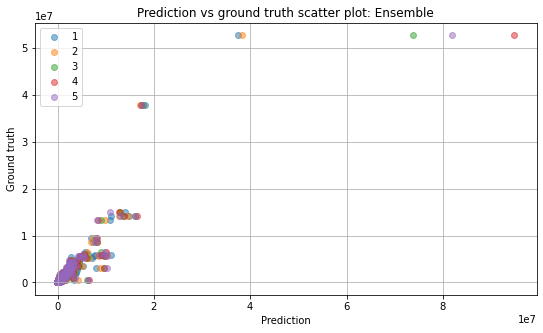

In [78]:
# Test score가 높은 순으로 입력 
ensemble_list = [ ('xgb', xgb_model),
                 ('rf', rf_model),
                  ('mlp', mlp_model),
                  ('en', en_model),
                  ('knn', knn_model) ]

# score 저장용 list 생성
train_perf_ens = []
test_perf_ens = []

# voting estimator를 저장할 list 생성
voting_est = []

# 각각의 모델을 앙상블
for idx, target_model in enumerate(ensemble_list):
    voting_est.append(target_model) # 모델 이름 저장

    voting_clf = VotingRegressor(estimators=voting_est, n_jobs=-1) # voting classifier 지정
    voting_clf.fit(x_train_scaled, y_train) # 데이터 입력
    y_train_pred = voting_clf.predict(x_train_scaled) 
    y_test_pred = voting_clf.predict(x_test_scaled)
    
    # 결과 출력
    train_score =  r2_score(y_train_pred, y_train)
    print(idx + 1, 'Ensemble train score:',train_score)
    test_score = r2_score(y_test_pred, y_test)
    print(idx + 1, 'Ensemble test  score:', test_score, '\n')
    
    #model_name.append(target_model)
    train_perf_ens.append(train_score)
    test_perf_ens.append(test_score)
    
    # 결과 시각화
    plt.scatter(y_test_pred, y_test, label=str(idx + 1), alpha=0.5)
    title = 'Prediction vs ground truth scatter plot: Ensemble'     
    plt.title(title)
    plt.xlabel('Prediction')
    plt.ylabel('Ground truth')
    plt.grid()
    plt.legend()

- Test score가 가장 높은 3번째 Ensemble가 가장 좋은 조합으로 판단된다.

## Ensemble결과 시각화

In [79]:
dic2 = {
        'train_perf_ens':train_perf_ens,
        'test_perf_ens':test_perf_ens
        }

MPC2 = pd.DataFrame.from_dict(dic2, orient='index')
MPC2

,0,1,2,3,4
train_perf_ens,1.00,0.98,0.95,0.91,0.95
test_perf_ens,0.77,0.76,0.86,0.78,0.82


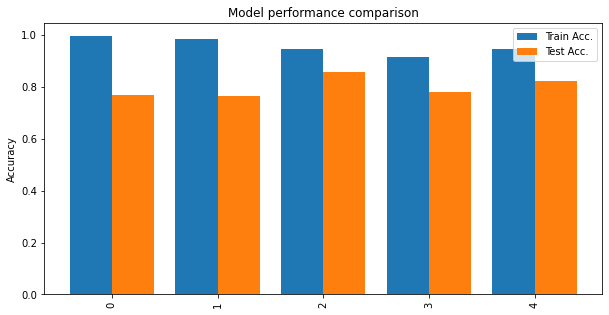

In [80]:
plt.rcParams['figure.figsize'] = (10, 5)
plt.title('Model performance comparison')
plt.xticks(rotation=90)
plt.ylabel('Accuracy')

x = np.arange(5)
plt.xticks(x)
plt.bar(x - 0.2, train_perf_ens, width=0.4, label='Train Acc.')
plt.bar(x + 0.2, test_perf_ens, width=0.4, label='Test Acc.')
plt.legend();

In [82]:
# 가장 성능이 좋은 3번째 Ensemble로 모델 선언
voting_clf = VotingRegressor(estimators=[('xgb', xgb_model), ('rf', rf_model), ('mlp', mlp_model)],
                             n_jobs=-1)
voting_clf.fit(x_train_scaled, y_train)

VotingRegressor(estimators=[('xgb',
                             XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          enable_categorical=False, gamma=None,
                                          gpu_id=None, importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=3,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=No...
                                          scale_pos_weight=None, subsample=None,
                                          tree_method=None,
                                        

# 최적 Voting 모델의 특성(피쳐) 중요도 분석

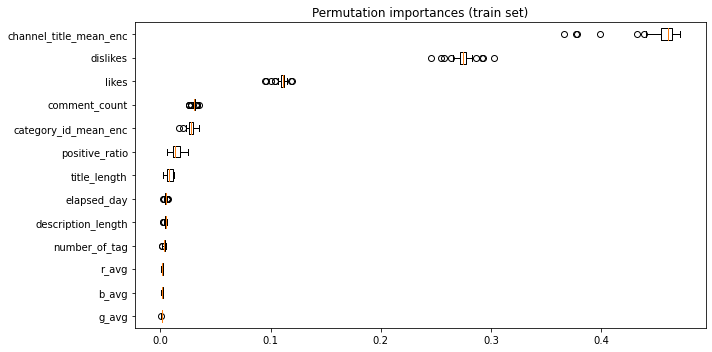

In [83]:
result = permutation_importance(voting_clf, x_train_scaled, y_train, n_repeats=100, n_jobs=-1, random_state=42)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T, vert=False, labels=x_train.columns[sorted_idx])
ax.set_title("Permutation importances (train set)")
fig.tight_layout()